In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import matplotlib as mpl
from scipy.io import loadmat

get_dir = os.getcwd()
os.chdir(get_dir)
np.random.seed(1234)

In [2]:
def get_fvalues(X, Y, T, nue):
    
    u_val = -np.cos(np.pi * X) * np.sin(np.pi * Y) * np.exp(-2 * np.pi ** 2 * nue * T)
    v_val = np.sin(np.pi * X) * np.cos(np.pi * Y) * np.exp(-2 * np.pi ** 2 * nue * T)
    p_val = (-((np.cos(2 * np.pi * X) + np.cos(2 * np.pi * Y)) / 4) *
             np.exp(-4 * np.pi ** 2 * nue * T))
    
    return u_val, v_val, p_val

def get_predictions(model, test_data):
    
    u_test, v_test, p_test = model.predict(test_data, batch_size=4096)
    return u_test, v_test, p_test
def get_repeated_tensors(x, y, t, u, v, p, num_samples):
    return (np.repeat(x.reshape((1, -1)), num_samples, axis=0), 
           np.repeat(y.reshape((1, -1)), num_samples, axis=0),
           np.repeat(t.reshape((1, -1)), num_samples, axis=0),
           np.repeat(u.reshape((1, -1)), num_samples, axis=0),
           np.repeat(v.reshape((1, -1)), num_samples, axis=0),
           np.repeat(p.reshape((1, -1)), num_samples, axis=0))

In [3]:
def get_true_test_values(model, nue, xlim, ylim, tlim, grid_size, tval, seq_dir, TP=True):
    
    true_val = []
    pred_val = []
    u_val = {'true': [], 'pred': []}
    v_val = {'true': [], 'pred': []}
    
    xdisc = np.linspace(start=xlim[0], stop=xlim[1], num=grid_size)
    ydisc = np.linspace(start=ylim[0], stop=ylim[1], num=grid_size)
    
    X, Y = np.meshgrid(xdisc, ydisc)
    grid_loc = np.hstack((X.flatten()[:, None], Y.flatten()[:, None], np.ones_like(X).flatten()[:, None]*tval))
    coord_val = pd.read_csv(seq_dir)
    x_seq, y_seq, t_seq = coord_val['0'].values, coord_val['1'].values, coord_val['2'].values
    
    for i in nue:
        u_seq, v_seq, p_seq = get_fvalues(x_seq, y_seq, t_seq, nue=i)
        xbc, ybc, tbc, ubc, vbc, pbc = get_repeated_tensors(x_seq, y_seq, t_seq, u_seq, v_seq, p_seq, num_samples=len(grid_loc))
        if TP:
            test_data = [grid_loc[:, 0:1], grid_loc[:, 1:2], grid_loc[:, 2:], xbc, ybc, tbc, ubc, vbc, pbc]
        else:
            test_data = [grid_loc[:, 0:1], grid_loc[:, 1:2], grid_loc[:, 2:], ubc, vbc, pbc]
        
        u_test, v_test, p_test = get_predictions(model, test_data)
        
        u_test = u_test.reshape(X.shape)
        v_test = v_test.reshape(X.shape)
    
        u_true, v_true, p_true = get_fvalues(X=grid_loc[:, 0:1], Y=grid_loc[:, 1:2], T=grid_loc[:, 2:], nue=i)
        
        u_true = u_true.reshape(X.shape)
        v_true = v_true.reshape(X.shape)
        
        true_mag = (u_true ** 2 + v_true ** 2)**0.5
        pred_mag = (u_test ** 2 + v_test ** 2)**0.5
        
        true_val.append(true_mag)
        pred_val.append(pred_mag)
        
        u_val['true'].append(u_true)
        u_val['pred'].append(u_test)
        v_val['true'].append(v_true)
        v_val['pred'].append(v_test)
        
    return X, Y, true_val, pred_val, u_val, v_val

In [4]:
def get_plots(x, y, true_val, pred_val, u_val, v_val, grid_spec, plot_title, plot_save, 
              plot_dir, fig_size,shrink=1, dm=False, lxd = [0.5, 0.5],lyd=[0.1, 0.9], 
              lx=0.25, rx=0.75, text_y=0.9, clim=[0., 1.], eclim = [0., 0.035], 
              lbs=['PINTO Prediction \n Y', 'Analytical Solution \n Y', 'Relative Error \n Y'], 
              dt=['Seen', 'Unseen'], cbar_kwargs=None):
    
    fig, ax = plt.subplots(3, len(true_val),figsize=fig_size, sharex='col', sharey='row', 
                           gridspec_kw =grid_spec)

    # Create two GridSpec objects for left and right sections
    gs = mpl.gridspec.GridSpec(4, 4, figure=fig)
    
    def fmt(x, pos):
        return f'{x:.1e}'

    
    for j in range(len(true_val)):
        
        # level = np.linspace(true_val[j].min(), true_val[j].max(), num=7)
        level = np.linspace(clim[0], clim[1], num=10)
        err_level = np.linspace(eclim[0], eclim[1], num=7)
    
        pres = ax[0][j].streamplot(x, y, u_val['pred'][j], v_val['pred'][j], color='k', 
                                    linewidth=0.5)
        pre = ax[0][j].contourf(x, y, pred_val[j], level, cmap='rainbow')

        trus = ax[1][j].streamplot(x, y, u_val['true'][j], v_val['true'][j], color='k', 
                                    linewidth=0.5)
        ref = ax[1][j].contourf(x, y, true_val[j], level, cmap='rainbow')
        
        rel_err = np.log10(abs(true_val[j] - pred_val[j])/(1 + abs(true_val[j])))
        
        if dm:
            er = ax[2][j].contourf(x, y, rel_err, err_level, cmap='Blues',extend='both')
            er.cmap.set_under('orange')
            er.cmap.set_over('orange')
        else:
            er = ax[2][j].contourf(x, y, rel_err, err_level, cmap='Blues')
        
        ax[0][j].set_title(plot_title[0][j],fontsize=10, fontweight='bold')
        ax[0][j].set_xlim(xlim[0], xlim[1])
        ax[0][j].set_ylim(ylim[0], ylim[1])

        
        ax[1][j].set_xlim(xlim[0], xlim[1])
        ax[1][j].set_ylim(ylim[0], ylim[1])
        
        ax[2][j].set_xlabel('X', fontsize=10, fontweight='bold')

        for row in ax:
            row[j].set_aspect('equal', adjustable='box')
        
    pcbar = fig.colorbar(pre, ax=ax[0, :], **cbar_kwargs)
    pcbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
    pcbar.set_label('|V| (non-dim)', fontsize=10, fontweight='bold')
    
    tcbar = fig.colorbar(ref, ax=ax[1, :], **cbar_kwargs)
    tcbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
    tcbar.set_label('|V| (non-dim)', fontsize=10, fontweight='bold')
    
    ecbar = fig.colorbar(er, ax = ax[2, :], **cbar_kwargs)
    ecbar.set_label('Log$_{10}$(Relative Error)', fontsize=10, fontweight='bold')
    
    # ecbar.formatter = tick.FuncFormatter(fmt)
    # ecbar.update_ticks()
    
    ax[0][0].set_ylabel(lbs[0], fontsize=10, fontweight='bold')
    ax[1][0].set_ylabel(lbs[1], fontsize=10, fontweight='bold')
    ax[2][0].set_ylabel(lbs[2], fontsize=10, fontweight='bold')
    
    fig.text(lx, text_y, dt[0], ha='center', va='center', fontsize=12, fontweight='bold')
    fig.text(rx, text_y, dt[1], ha='center', va='center', fontsize=12, fontweight='bold')

    # Add vertical line using figure coordinates
    line = plt.Line2D(lxd, lyd, transform=fig.transFigure, color='black', linewidth=2)
    fig.add_artist(line)
    
    if plot_save:
        plt.savefig(plot_dir + '.png', dpi=300, bbox_inches = 'tight', format='png')

## Figure_8: Beltrami Flow 

In [5]:
PINTO_model = keras.models.load_model('../Trained_models/Beltrami_PINTO/Beltrami_PINTO_model/')
train_test_nue = [1/10, 1/50, 1/20, 1/30]

xlim = [-1., 1.0]
ylim = [-1., 1.0]
tlim = [0, 1.0]

grid_size = 64
bound_points = 20
seq_dir = '../Trained_models/Beltrami_PINTO/seq.csv'

x, y, tno_true, tno_pred, tno_u_val, tno_v_val = get_true_test_values(
    model=PINTO_model, nue=train_test_nue, 
    xlim=xlim, ylim=ylim, tlim=tlim, grid_size=grid_size, 
    tval=0.5, seq_dir=seq_dir)

1/1 [==============================] - 0s 24ms/step


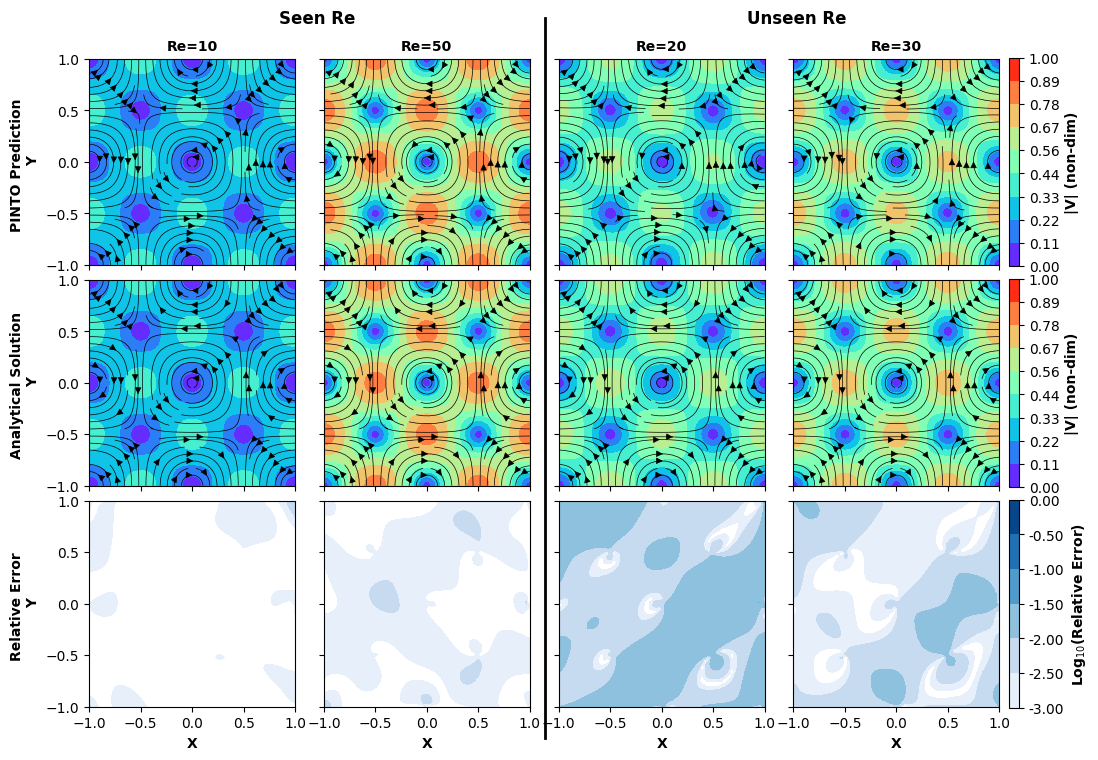

In [6]:
pdir = 'Figure_8'
pt = [['Re=10', 'Re=50', 'Re=20', 'Re=30']] #plot titles for each column
plt_save = False # argument to save the plot 
clim = [0., 1.] # prediction and analytical solution contour plots colorbar limits
eclim = [-3., 0.] # error color bar limits 
cbar_kwargs = {
        'fraction': 0.0112, 
        'pad': 0.01,
        'format': tick.FormatStrFormatter('%.2f')
    }

grid_spec = {'wspace': 0.14, 'hspace': -0.12, 'width_ratios':[1, 1, 1, 1], 'height_ratios':[1, 1, 1]}
get_plots(x,  y, true_val=tno_true, pred_val=tno_pred, u_val=tno_u_val, v_val=tno_v_val, 
          plot_save=plt_save, grid_spec=grid_spec, 
          plot_title=pt, plot_dir=pdir, fig_size=(12,9), shrink=1,
          lxd=[0.505, 0.505], lyd=[0.1, 0.9], 
          lx=0.315, rx=0.715, text_y=0.9, clim=clim, eclim=eclim,
          lbs=['PINTO Prediction \n Y', 'Analytical Solution \n Y', 'Relative Error \n Y'], 
	  dt=['Seen Re', 'Unseen Re'], cbar_kwargs=cbar_kwargs)

## PI-DeepONets Plots

In [7]:
pid_model = tf.keras.models.load_model('../Trained_models/Beltrami_DeepONet/Beltrami_Deeponet_model.keras')

seq_dir = '../Trained_models/Beltrami_DeepONet/seq.csv'

x, y, pid_true, pid_pred, pid_u_val, pid_v_val = get_true_test_values(
    model=pid_model, nue=train_test_nue, 
    xlim=xlim, ylim=ylim, tlim=tlim, grid_size=grid_size, tval=0.5, seq_dir=seq_dir, TP=False)

1/1 [==============================] - 0s 19ms/step


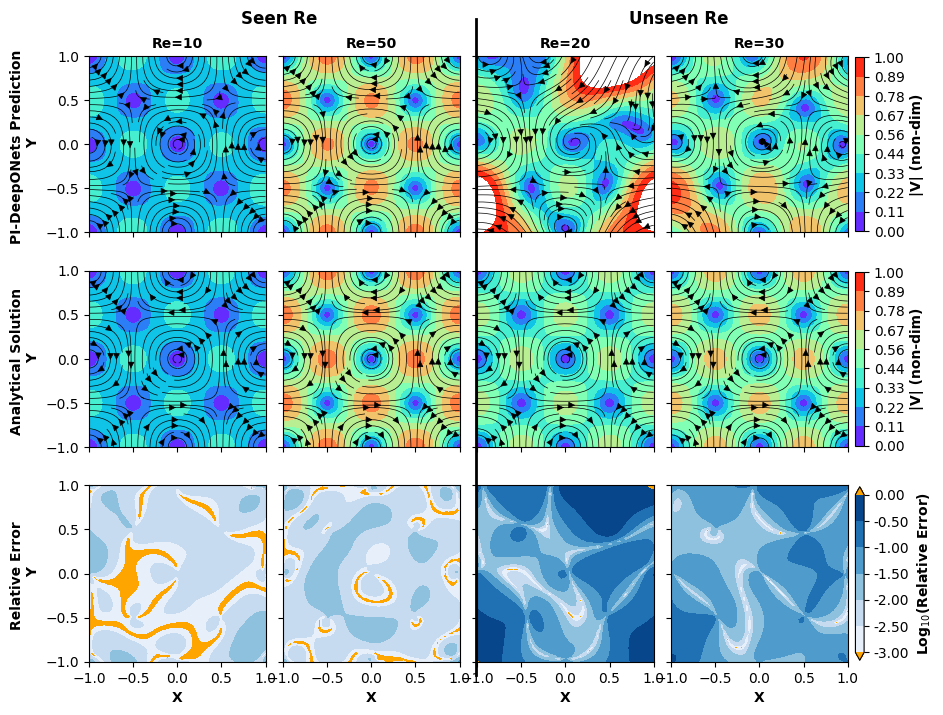

In [8]:
pdir = 'PID_Beltrami_training_testing_plots'
pt = [['Re=10', 'Re=50', 'Re=20', 'Re=30']] #plot titles for each column
plt_save = False # argument to save the plot 
clim = [0., 1.] # prediction and analytical solution contour plots colorbar limits
eclim = [-3., 0.] # error color bar limits 

cbar_kwargs = {
        'fraction': 0.0112, 
        'pad': 0.01,
        'format': tick.FormatStrFormatter('%.2f')
    }

grid_spec = {'wspace': 0.1, 'hspace': 0.15, 'width_ratios':[1, 1, 1, 1], 'height_ratios':[1, 1, 1]}
get_plots(x,  y, true_val=pid_true, pred_val=pid_pred, u_val=pid_u_val, v_val=pid_v_val, 
          plot_save=plt_save, grid_spec=grid_spec, 
          plot_title=pt, plot_dir=pdir, fig_size=(10,8), shrink=1, dm=True,
          lxd=[0.512, 0.512], lyd=[0.1, 0.92], 
          lx=0.315, rx=0.715, text_y=0.92, clim=clim, eclim=eclim,
          lbs=['PI-DeepONets Prediction \n Y', 'Analytical Solution \n Y', 'Relative Error \n Y'], 
	  dt=['Seen Re', 'Unseen Re'], cbar_kwargs=cbar_kwargs)

## Table1: PerFormance Metrics

In [9]:
def get_true_test_values_across_time(model, nue, xlim, ylim, tlim, grid_size, seq_dir, TP=True):
    
    true_val = []
    pred_val = []
    u_val = {'true': [], 'pred': []}
    v_val = {'true': [], 'pred': []}
    
    xdisc = np.linspace(start=xlim[0], stop=xlim[1], num=grid_size)
    ydisc = np.linspace(start=ylim[0], stop=ylim[1], num=grid_size)
    tdisc = np.linspace(start=tlim[0], stop=tlim[1], num=grid_size)
    
    X, Y, T = np.meshgrid(xdisc, ydisc, tdisc)
    grid_loc = np.hstack((X.flatten()[:, None], Y.flatten()[:, None], T.flatten()[:, None]))
    coord_val = pd.read_csv(seq_dir)
    x_seq, y_seq, t_seq = coord_val['0'].values, coord_val['1'].values, coord_val['2'].values
    
    for i in nue:
        u_seq, v_seq, p_seq = get_fvalues(x_seq, y_seq, t_seq, nue=i)
        xbc, ybc, tbc, ubc, vbc, pbc = get_repeated_tensors(x_seq, y_seq, t_seq, u_seq, v_seq, p_seq, num_samples=len(grid_loc))
        if TP:
            test_data = [grid_loc[:, 0:1], grid_loc[:, 1:2], grid_loc[:, 2:], xbc, ybc, tbc, ubc, vbc, pbc]
        else:
            test_data = [grid_loc[:, 0:1], grid_loc[:, 1:2], grid_loc[:, 2:], ubc, vbc, pbc]
        
        u_test, v_test, p_test = get_predictions(model, test_data)
        
        u_test = u_test.reshape(X.shape)
        v_test = v_test.reshape(X.shape)
    
        u_true, v_true, p_true = get_fvalues(X=grid_loc[:, 0:1], Y=grid_loc[:, 1:2], T=grid_loc[:, 2:], nue=i)
        
        u_true = u_true.reshape(X.shape)
        v_true = v_true.reshape(X.shape)
        
        true_mag = (u_true ** 2 + v_true ** 2)**0.5
        pred_mag = (u_test ** 2 + v_test ** 2)**0.5
        
        true_val.append(true_mag)
        pred_val.append(pred_mag)
        
        u_val['true'].append(u_true)
        u_val['pred'].append(u_test)
        v_val['true'].append(v_true)
        v_val['pred'].append(v_test)
        
    return X, Y, true_val, pred_val, u_val, v_val

In [10]:
def get_metrics(true_val, pred_val):

	rel_err = abs(np.concatenate(true_val, axis=0) - np.concatenate(pred_val, axis=0))/(1 + abs(np.concatenate(true_val, axis=0)))
	mean_metric = np.mean(rel_err)
	std_metric = np.std(rel_err)

	return mean_metric, std_metric

In [11]:
training_nue = [1/10, 1/50, 1/100]
testing_nue = 1/np.random.uniform(low=10., high=150., size=[1, 20]).reshape(-1)

In [12]:
xlim = [-1., 1.0]
ylim = [-1., 1.0]
tlim = [0, 2.0]

seq_dir = '../Trained_models/Beltrami_PINTO/seq.csv'

_, _, tno_train_true, tno_train_pred, tno_tr_u_val, tno_tr_v_val = get_true_test_values_across_time(
    model=PINTO_model, nue=training_nue, 
    xlim=xlim, ylim=ylim, tlim=tlim, grid_size=grid_size, 
    seq_dir=seq_dir)

_, _, tno_test_true, tno_test_pred, tno_ts_u_val, tno_ts_v_val = get_true_test_values_across_time(
    model=PINTO_model, nue=testing_nue, 
    xlim=xlim, ylim=ylim, tlim=tlim, grid_size=grid_size, 
    seq_dir=seq_dir)

64/64 [==============================] - 1s 13ms/step


In [13]:
seq_dir = '../Trained_models/Beltrami_DeepONet/seq.csv'

_, _, pid_train_true, pid_train_pred, pid_tr_u_val, pid_tr_v_val = get_true_test_values_across_time(
    model=pid_model, nue=training_nue, 
    xlim=xlim, ylim=ylim, tlim=tlim, grid_size=grid_size, 
    seq_dir=seq_dir, TP=False)

_, _, pid_test_true, pid_test_pred, pid_ts_u_val, pid_ts_v_val = get_true_test_values_across_time(
    model=pid_model, nue=testing_nue, 
    xlim=xlim, ylim=ylim, tlim=tlim, grid_size=grid_size, 
    seq_dir=seq_dir, TP=False)

64/64 [==============================] - 0s 5ms/step


In [14]:
train_mean_metric, train_std_metric = get_metrics(tno_train_true, tno_train_pred)
test_mean_metric, test_std_metric = get_metrics(tno_test_true, tno_test_pred)

print("PINTO metrics")
print("mean relative error across all training sets is: ",train_mean_metric)
print("std of relative error across training sets is: ",train_std_metric)
print("mean relative error across all testing sets is: ",test_mean_metric)
print("std of relative error across testing sets is: ",test_std_metric)

PINTO metrics
mean relative error across all training sets is:  0.0052792373541478005
std of relative error across training sets is:  0.009910420456801322
mean relative error across all testing sets is:  0.006000345937597302
std of relative error across testing sets is:  0.009166834384349997


In [15]:
train_mean_metric, train_std_metric = get_metrics(pid_train_true, pid_train_pred)
test_mean_metric, test_std_metric = get_metrics(pid_test_true, pid_test_pred)

print("PI-DeepONet metrics")
print("mean relative error across all training sets is: ",train_mean_metric)
print("std of relative error across training sets is: ",train_std_metric)
print("mean relative error across all testing sets is: ",test_mean_metric)
print("std of relative error across testing sets is: ",test_std_metric)

PI-DeepONet metrics
mean relative error across all training sets is:  0.026280087906833102
std of relative error across training sets is:  0.041882824951693036
mean relative error across all testing sets is:  0.048903510470302294
std of relative error across testing sets is:  0.12140028814290045


## Analysis with Re 

In [16]:
testing_nue = 1/np.linspace(15., 300., 50).reshape(-1)

xlim = [-1., 1.0]
ylim = [-1., 1.0]
tlim = [0, 2.0]

grid_size = 64
seq_dir = '../Trained_models/Beltrami_PINTO/seq.csv'

_, _, tno_train_true, tno_train_pred, tno_tr_u_val, tno_tr_v_val = get_true_test_values_across_time(
    model=PINTO_model, nue=testing_nue, 
    xlim=xlim, ylim=ylim, tlim=tlim, grid_size=grid_size, 
    seq_dir=seq_dir)

64/64 [==============================] - 1s 13ms/step


In [17]:
rel_err = []
for i in range(50):
	rel_err.append(np.mean(abs(tno_train_true[i]-tno_train_pred[i])/(1 + abs(tno_train_true[i]))))
re_df = pd.DataFrame({'testing_Re': 1/testing_nue, 'rel_er': rel_err})
re_df.to_csv('Relative_error_vs_Re.csv')

## Appendix G: Computational Time 

In [18]:
xdisc = np.linspace(0, 1, 64)
ydisc = np.linspace(0, 1, 64)
tdisc = np.linspace(0, 1, 20)
X, Y, T = np.meshgrid(xdisc, ydisc, tdisc)
xin = X.reshape((-1, 1))
yin  = Y.reshape((-1, 1))
tin = T.reshape((-1, 1))
x_sen = np.random.rand(len(xin), 100)
y_sen = np.random.rand(len(xin), 100)
t_sen = np.random.rand(len(xin), 100)
u_sen = np.random.rand(len(xin), 100)
v_sen = np.random.rand(len(xin), 100)
p_sen = np.random.rand(len(xin), 100)

_ = PINTO_model.predict([xin, yin, tin, x_sen, y_sen, t_sen, u_sen, v_sen, p_sen], batch_size=64*64*20, verbose=0)
for i in range(10):
    _ = PINTO_model.predict([xin, yin, tin, x_sen, y_sen, t_sen, u_sen, v_sen, p_sen], batch_size=64*64*20)

1/1 [==============================] - 0s 274ms/step
